# Q-learningの考え方を迷路問題を用いて確認する

In [1]:
import numpy as np
from collections import defaultdict
from common.agent import CommonAgent
from common.show_value import show_q_value,show_v_value
from common.meiro import Environment
import matplotlib.pyplot as plt

In [2]:
class QLearningAgent(CommonAgent):
    """
    Q学習法のエージェントクラス
    """
    
    def __init__(self, epsilon=0.1):
        """
        epsilon : float, 探索する確率
        """
        # CommonAgentクラスの__init__メソッドを実行する
        super().__init__(epsilon)
    
    def policy(self, s, actions):
        """
        方策関数(epsilon-greedy法)
        """
        if np.random.random() < self.epsilon:
            """
            探索
            """
            return np.random.choice(actions)
        else:
            """
            利用
            """
            if s in self.Q and sum(self.Q[s]) != 0:
                # 行動価値Qが最大になる行動aのインデックスを返す
                return np.argmax(self.Q[s])
            else:
                """
                例外処理
                """
                return np.random.choice(actions)

    def learn(self, env, episode_num=1000, gamma=0.9, report_interval=50, alpha=0.01):
        """
        学習を実行するメソッド
        episode_num : エピソード数
        gamma : 割引率
        report_interval : 結果を表示させる間隔
        alpha : 学習率
        """
        
        # 初期化
        self.init_log()
        actions = env.actions # 行動の種類
        num_actions = len(actions)
        self.Q = defaultdict(lambda: [0] * num_actions) # 行動価値
        
        # エピソードのループ
        for e in range(episode_num):
            
            # 初期化
            s = env.reset()
            done = False
            
            # 1エピソードを実行
            while not done:
                
                # 現在の方策に基づいて、行動をとる
                a = self.policy(s, actions)
                next_state, reward, done = env.step(a)
                
                # TD誤差を求める
                gain = reward + gamma * max(self.Q[next_state]) # 行動価値が最大になる行動が最善であると考える
                estimated = self.Q[s][a]
                td = (gain - estimated) 
                
                # 行動価値Qを更新する
                self.Q[s][a] += alpha *td 
                
                # 状態を更新する
                s = next_state

            # 最後の報酬を記録しておく
            self.log(reward)

            # 報酬を表示する
            if e != 0 and e % report_interval == 0:
                self.show_rewards_log(episode=e)
class SARSAAgent(CommonAgent):
    def __init__(self, epsilon=0.1):
        """
        epsilon : float, 探索する確率
        """
        super().__init__(epsilon)
    
    def policy(self, s, actions):
        """
        方策関数(epsilon-greedy法)
        """
        if np.random.random() < self.epsilon:
            """
            探索
            """
            return np.random.choice(actions)
        
        else:
            """
            利用
            """
            if s in self.Q and sum(self.Q[s]) !=0:
                # 行動価値Qが最大になる行動aのインデックスを返す
                return np.argmax(self.Q[s])
            else:
                """
                例外処理
                """
                return np.random.choice(actions)
            
    def learn(self, env, episode_num=1000, gamma=0.9, report_interval=50, alpha=0.01):
        """
        学習を実行するメソッド
        episode_num : エピソード数
        gamma : 割引率
        report_interval : 結果を表示させる間隔
        alpha : 学習率
        """
                
        # 初期化
        self.init_log()
        actions = env.actions # 行動の種類
        num_actions = len(actions)
        self.Q = defaultdict(lambda: [0] * num_actions)
        
        # エピソードのループ
        for e in range(episode_num):
            
            # initilize
            s = env.reset()
            done = False
            a = self.policy(s, actions)
            
            while not done:
                next_state, reward, done = env.step(a)
                next_action = self.policy(next_state, actions)
                gain = reward + gamma * self.Q[next_state][next_action]
                estimated= self.Q[s][a]
                td = gain - estimated
                
                self.Q[s][a] += alpha * (td)
                
                s = next_state
                a = next_action
            
            self.log(reward)
            if e != 0 and e% report_interval == 0:
                self.show_rewards_log(episode=e)
            
class Actor(CommonAgent):
    """
    Actor(戦略担当)のクラス
    """
    def __init__(self, env):
        # CommonAgentクラスの__init__メソッドを実行する
        super().__init__(epsilon=-1)
        
        nrow = env.row_length
        ncol = env.col_length
        self.actions = env.actions
        num_actions = len(self.actions)
        
        # 0-1のランダム値で初期化
        self.Q = defaultdict(lambda: [0] * num_actions) # 行動価値
        for s in env.states:
            if env.grid[s.row, s.col]==0:
                """
                通常セルにだけ行動価値を割り当てる
                """
                self.Q[s] = np.random.uniform(0, 1, size=num_actions)

    def softmax(self, x):
        """
        ソフトマックス関数
        """
        return np.exp(x) / np.sum(np.exp(x))

    def policy(self, s):
        """
        方策関数
        """
        # 行動価値に基づいて、確率的に行動を選択する
        prob = self.softmax(self.Q[s])
        return np.random.choice(self.actions, size=1, p=prob)


class Critic():
    """
    Critic(評価担当)のクラス
    """
    def __init__(self, env):
        states = env.states

        # 0で初期化
        self.V = defaultdict(lambda:0) # 状態価値
        for s in env.states:
            self.V[s] = 0
            

class ActorCriticAgent():
    """
    ActorCritic法によって行動価値を更新するためのエージェントクラス
    """
    
    def __init__(self, actor_class, critic_class):
        self.actor_class = actor_class
        self.critic_class = critic_class
   
    def learn(self, env, episode_num=1000, gamma=0.9, report_interval=50, alpha=0.01):
        """
        学習を実行するメソッド
        episode_num : エピソード数
        gamma : 割引率
        report_interval : 結果を表示させる間隔
        alpha : 学習率
        """
        
        # 初期化
        actor = self.actor_class(env)
        critic = self.critic_class(env)
        actor.init_log()
        
        # エピソードのループ
        for e in range(episode_num):
            
            # 初期化
            s = env.reset()
            done = False
            
            # 1エピソードを実行
            while not done:

                # actorの方策に基づいて、行動をとる
                a = actor.policy(s)
                next_state, reward, done = env.step(a)

                # TD誤差を求める
                gain = reward + gamma * critic.V[next_state]
                estimated = critic.V[s]
                td = gain - estimated # 状態価値の最適化を目指す
                
                # actorの行動価値Qを更新する
                actor.Q[s][a] += alpha * td
                
                # criticの状態価値Vを更新する
                critic.V[s] += alpha * td
                
                # 状態を更新する
                s = next_state


            # 最後の報酬を記録しておく
            actor.log(reward)

            # 報酬を表示する
            if e != 0 and e % report_interval == 0:
                actor.show_rewards_log(episode=e)

        return actor, critic            

## 実行

model:sarsa
model:Q
model:critic


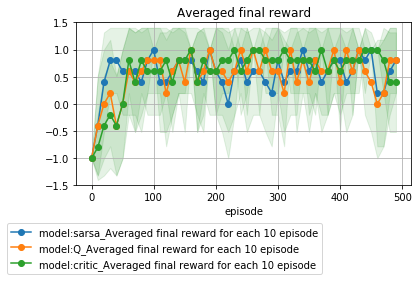

In [3]:
list = ["sarsa","Q","critic"]
plt.figure(figsize=(6,3))
plt.title("Averaged final reward")

for model in list:
    print(f"model:{model}")
    # 迷路の条件を設定する
    grid = np.array([[0,0,0,0],[0,-1,0,-1],[0,0,0,-1],[-1,0,0,1]])

    # 環境をつくる
    env = Environment(grid, move_prob=0.95, agent_init_state=(0,0))

    if model == "sarsa":
        agent = SARSAAgent(epsilon=0.1)
        agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)
        agent.show_rewards_log(interval=10, model=model)
    elif model == "Q":
        # エージェントをつくる
        agent = QLearningAgent(epsilon=0.1)
        agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)
        agent.show_rewards_log(interval=10, model=model)
    else:
        agent = ActorCriticAgent(Actor, Critic)

        # 学習の実行
        actor, critic = agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.5)
        actor.show_rewards_log(interval=10, model=model)
plt.show()

## 結果の可視化

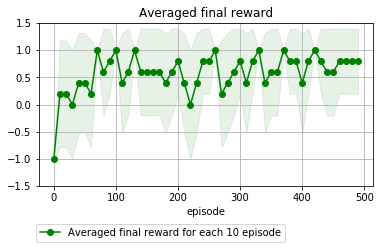

In [5]:
# agent.rewards_logに保存している各エピソードの最終報酬額を可視化する
# 全エピソードを表示させると傾向を捉えにくくなるため、10エピソード毎に平均をとっている
# 学習が進むと、エージェントはゴールできるようになってくるため、値は1(ゴール時の報酬)に近づく
agent.show_rewards_log(interval=10)

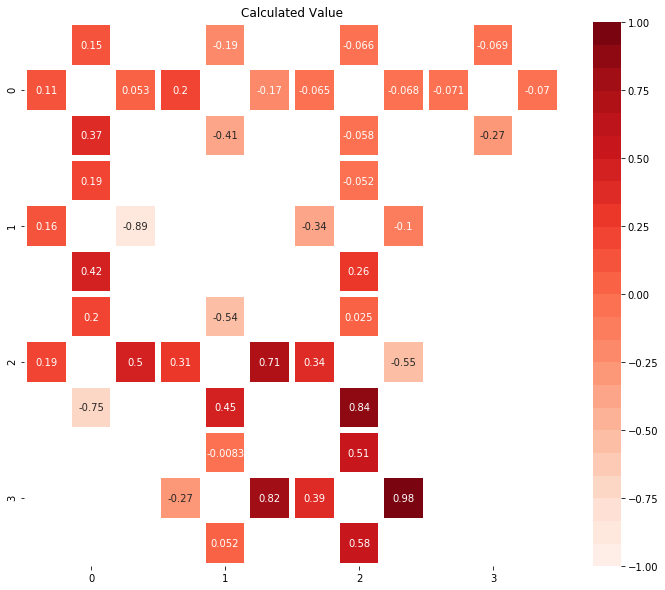

In [6]:
# 学習によって求めた行動価値Qを可視化する
# 行動価値は、通常セル毎に4つの値(UP,DOEN,LEFT,RIGTH)を持っている
# 以下のグラフでは、通常セルを中心に、上下左右の4つのセルに値を配置した
show_q_value(agent.Q, row=grid.shape[0], col=grid.shape[1])    

* SARSAにくらべ、全体的にQ値が大きくなっている。これは、行動価値が最大になる行動をとるように行動価値が更新されるため、穴に落ちるという行動がほとんど選択されないためである

### [演習]
* grid条件、エージェントの初期位置、epsilon、alphaなどを変更して、学習の進み具合を確認しましょう

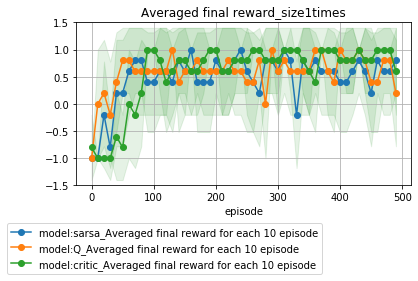

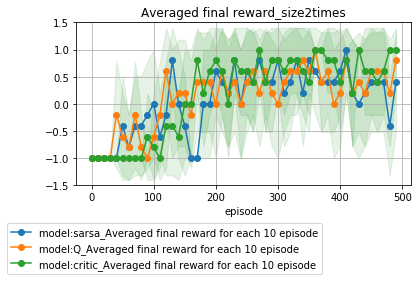

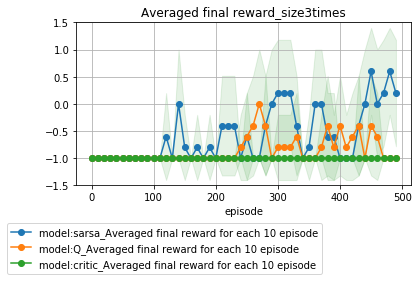

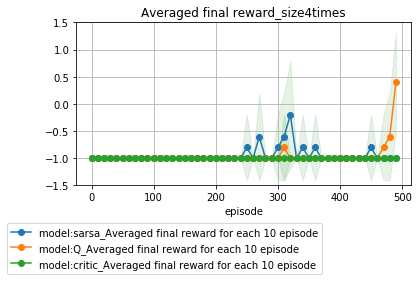

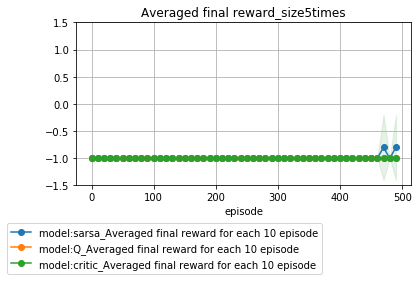

KeyboardInterrupt: 

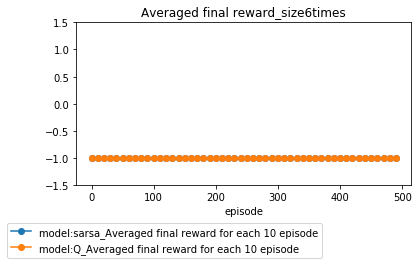

In [5]:
for i in range(1,10,1):
    list = ["sarsa","Q","critic"]
    plt.figure(figsize=(6,3))
    plt.title("Averaged final reward_size{}times".format(i))
#     print("Averaged final reward_size{}times".format(i))

    for model in list:
#         print(f"model:{model}") 
        a = [-1,0,0,0]*(i-1)
        a.extend([-1,0,0,1])
        grid = np.array([[0, 0, 0, 0]*i,[0, -1, 0, -1]*i,[0,0,0,-1]*i,a])
        env = Environment(grid, move_prob=0.95, agent_init_state=(0, 0))
        if model == "sarsa":
            agent = SARSAAgent(epsilon=0.1)
            agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)
            agent.show_rewards_log(interval=10, model=model)
        elif model == "Q":
            # エージェントをつくる
            agent = QLearningAgent(epsilon=0.1)
            agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)
            agent.show_rewards_log(interval=10, model=model)
        else:
            agent = ActorCriticAgent(Actor, Critic)

            # 学習の実行
            actor, critic = agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.5)
            actor.show_rewards_log(interval=10, model=model)
    plt.show()
    plt.close()

In [ ]:
サイズはsarsaと対して変わらない

# ゴールできない12x12で初期位置確認

初期位置(0,0)


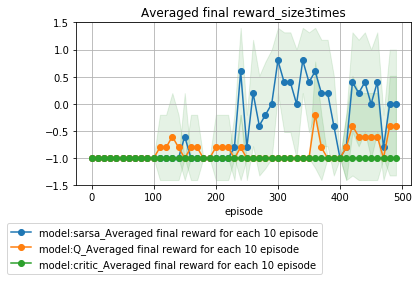

初期位置(0,4)


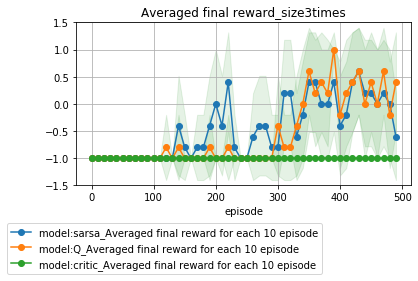

初期位置(0,8)


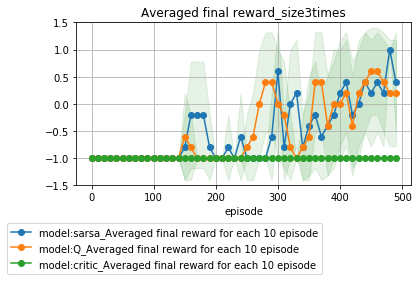

初期位置(4,0)


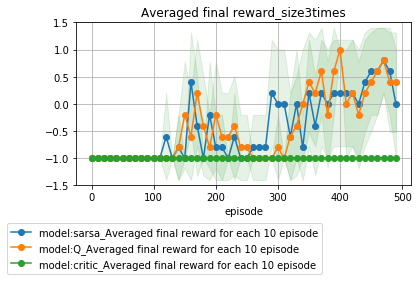

初期位置(4,4)


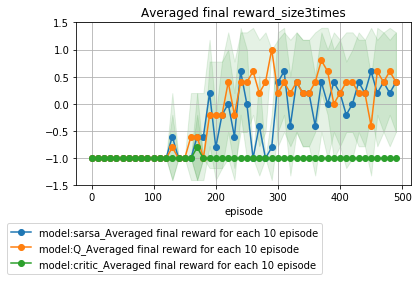

初期位置(4,8)


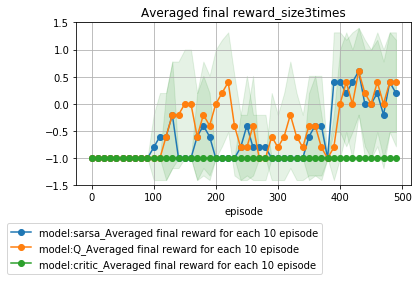

初期位置(8,0)


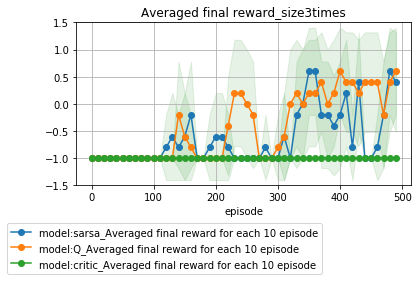

初期位置(8,4)


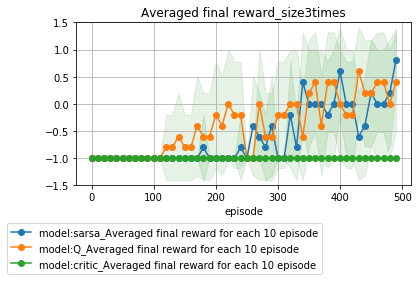

初期位置(8,8)


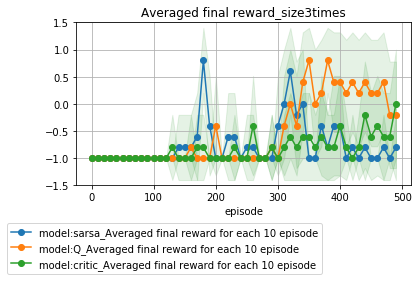

In [11]:
i=3
for j in range(0,4*i,4):
    for k in range(0,4*i,4):        
        list = ["sarsa","Q","critic"]
        plt.figure(figsize=(6,3))
        plt.title("Averaged final reward_size{}times".format(i))
        print("初期位置({},{})".format(j,k))

        for model in list:

            a = [-1,0,0,0]*(i-1)
            a.extend([-1,0,0,1])
            grid = np.array([[0, 0, 0, 0]*i,[0, -1, 0, -1]*i,[0,0,0,-1]*i,a])
            env = Environment(grid, move_prob=0.95, agent_init_state=(j, k))
            if model == "sarsa":
                agent = SARSAAgent(epsilon=0.1)
                agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)
                agent.show_rewards_log(interval=10, model=model)
            elif model == "Q":
                # エージェントをつくる
                agent = QLearningAgent(epsilon=0.1)
                agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)
                agent.show_rewards_log(interval=10, model=model)
            else:
                agent = ActorCriticAgent(Actor, Critic)

                # 学習の実行
                actor, critic = agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.5)
                actor.show_rewards_log(interval=10, model=model)
        plt.show()
        plt.close()

criticは収束が遅いため、サイズ大で報酬減

# 3x3で壁にする

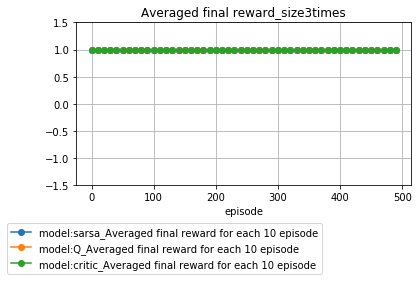

In [12]:
i=3

list = ["sarsa","Q","critic"]
plt.figure(figsize=(6,3))
plt.title("Averaged final reward_size{}times".format(i))
for model in list:
    a = [9,0,0,0]*(i-1)
    a.extend([9,0,0,1])
    grid = np.array([[0, 0, 0, 0]*i,[0, 9, 0, 9]*i,[0,0,0,9]*i,a])
    env = Environment(grid, move_prob=0.95, agent_init_state=(j, k))

    if model == "sarsa":
        agent = SARSAAgent(epsilon=0.1)
        agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)
        agent.show_rewards_log(interval=10, model=model)
    elif model == "Q":
        # エージェントをつくる
        agent = QLearningAgent(epsilon=0.1)
        agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)
        agent.show_rewards_log(interval=10, model=model)
    else:
        agent = ActorCriticAgent(Actor, Critic)

        # 学習の実行
        actor, critic = agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.5)
        actor.show_rewards_log(interval=10, model=model)
plt.show()
plt.close()

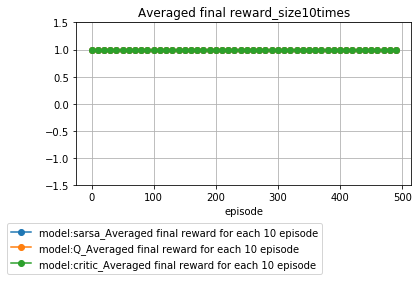

In [13]:
i=10

list = ["sarsa","Q","critic"]
plt.figure(figsize=(6,3))
plt.title("Averaged final reward_size{}times".format(i))
for model in list:
    a = [9,0,0,0]*(i-1)
    a.extend([9,0,0,1])
    grid = np.array([[0, 0, 0, 0]*i,[0, 9, 0, 9]*i,[0,0,0,9]*i,a])
    env = Environment(grid, move_prob=0.95, agent_init_state=(j, k))

    if model == "sarsa":
        agent = SARSAAgent(epsilon=0.1)
        agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)
        agent.show_rewards_log(interval=10, model=model)
    elif model == "Q":
        # エージェントをつくる
        agent = QLearningAgent(epsilon=0.1)
        agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)
        agent.show_rewards_log(interval=10, model=model)
    else:
        agent = ActorCriticAgent(Actor, Critic)

        # 学習の実行
        actor, critic = agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.5)
        actor.show_rewards_log(interval=10, model=model)
plt.show()
plt.close()

# epsilon

epsilon:1e-05


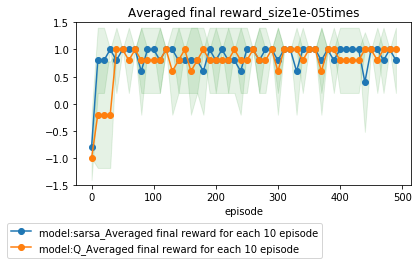

epsilon:0.10001


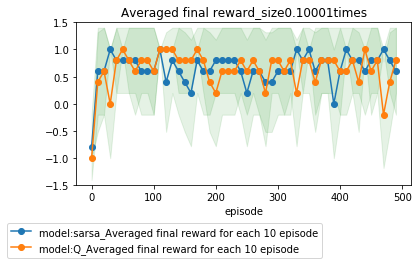

epsilon:0.20001000000000002


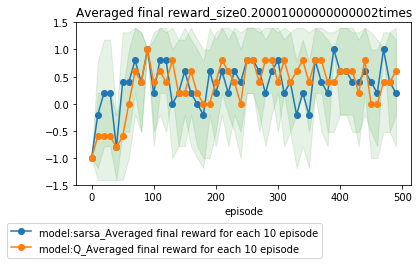

epsilon:0.30001000000000005


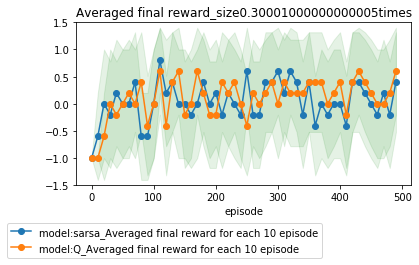

epsilon:0.40001000000000003


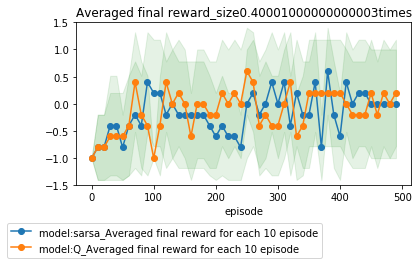

epsilon:0.50001


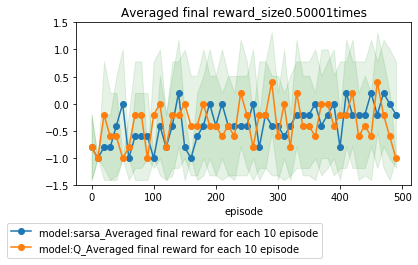

In [14]:
for i in np.arange(1e-5,0.6,0.1):
    print(f"epsilon:{i}")


    list = ["sarsa","Q","critic"]
    plt.figure(figsize=(6,3))
    plt.title("Averaged final reward_size{}times".format(i))
    for model in list:
        grid = np.array([[0, 0, 0, 0],[0, -1, 0, -1],[0,0,0,-1],[-1,0,0,1]])
        env = Environment(grid, move_prob=0.95, agent_init_state=(j, k))
        if model == "sarsa":
            agent = SARSAAgent(epsilon=i)
            agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)
            agent.show_rewards_log(interval=10, model=model)
        elif model == "Q":
            # エージェントをつくる
            agent = QLearningAgent(epsilon=i)
            agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)
            agent.show_rewards_log(interval=10, model=model)
        else:
            pass
#             agent = ActorCriticAgent(Actor, Critic)

#             # 学習の実行
#             actor, critic = agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.5)
#             actor.show_rewards_log(interval=10, model=model)
    plt.show()
    plt.close()

イプシロン大で報酬減

# alpha

alpha:1e-05


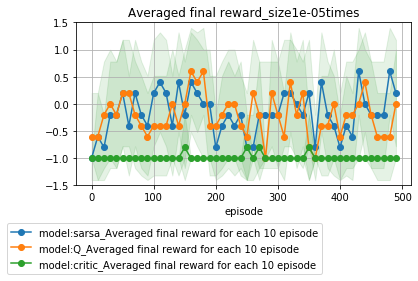

alpha:0.10001


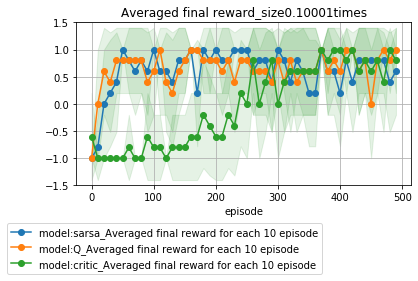

alpha:0.20001000000000002


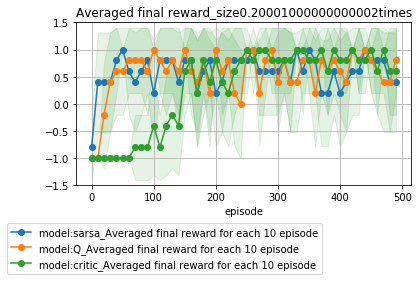

alpha:0.30001000000000005


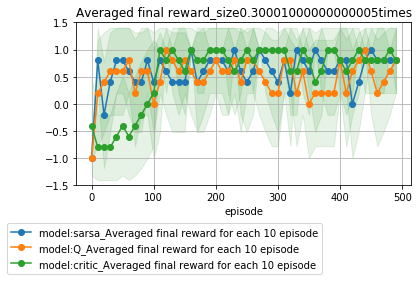

alpha:0.40001000000000003


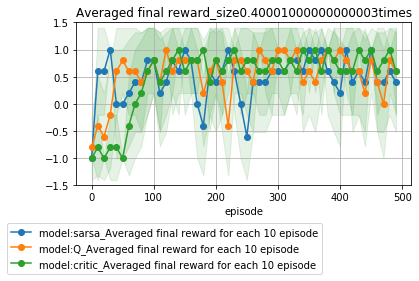

alpha:0.50001


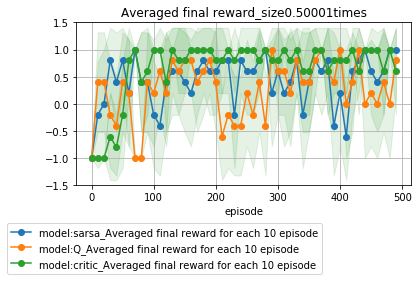

In [15]:
for i in np.arange(1e-5,0.6,0.1):
    print(f"alpha:{i}")

    list = ["sarsa","Q","critic"]
    plt.figure(figsize=(6,3))
    plt.title("Averaged final reward_size{}times".format(i))
    for model in list:
        grid = np.array([[0, 0, 0, 0],[0, -1, 0, -1],[0,0,0,-1],[-1,0,0,1]])
        env = Environment(grid, move_prob=0.95, agent_init_state=(j, k))
        if model == "sarsa":
            agent = SARSAAgent(epsilon=0.1)
            agent.learn(env, gamma=0.9,  episode_num=500, alpha=i)
            agent.show_rewards_log(interval=10, model=model)
        elif model == "Q":
            # エージェントをつくる
            agent = QLearningAgent(epsilon=0.1)
            agent.learn(env, gamma=0.9,  episode_num=500, alpha=i)
            agent.show_rewards_log(interval=10, model=model)
        else:
            pass
            agent = ActorCriticAgent(Actor, Critic)

            # 学習の実行
            actor, critic = agent.learn(env, gamma=0.9,  episode_num=500, alpha=i)
            actor.show_rewards_log(interval=10, model=model)
    plt.show()
    plt.close()

SARSA/Qはアルファ大で不安定、criticは安定

# gamma

gamma:0.000010


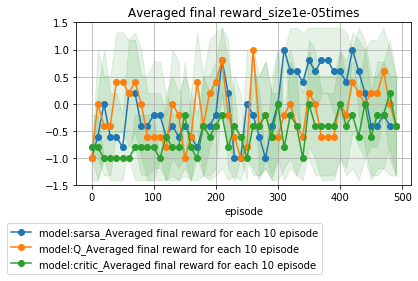

gamma:0.100010


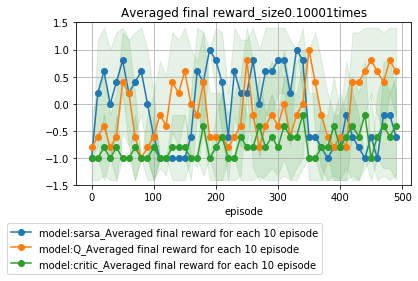

gamma:0.200010


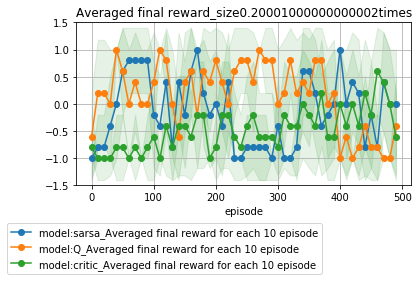

gamma:0.300010


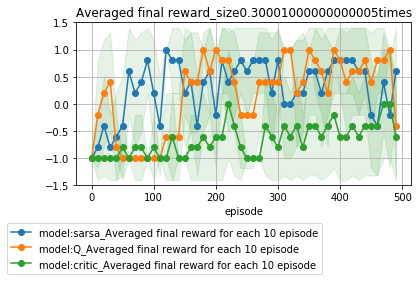

gamma:0.400010


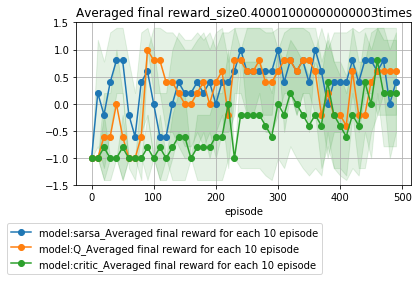

gamma:0.500010


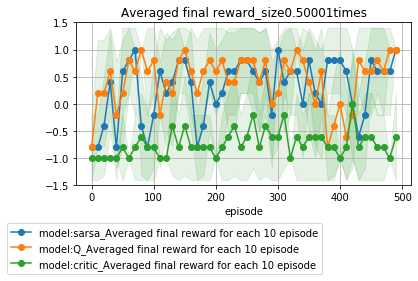

gamma:0.600010


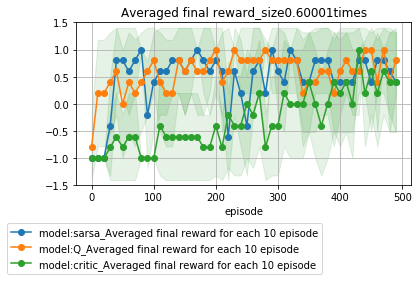

gamma:0.700010


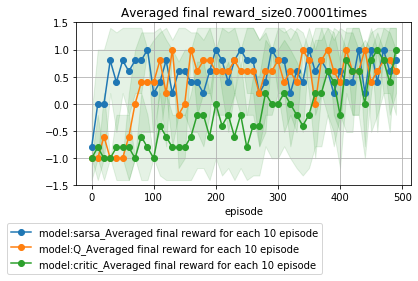

gamma:0.800010


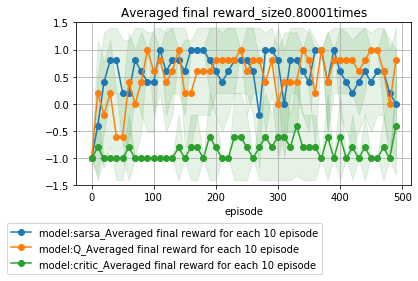

gamma:0.900010


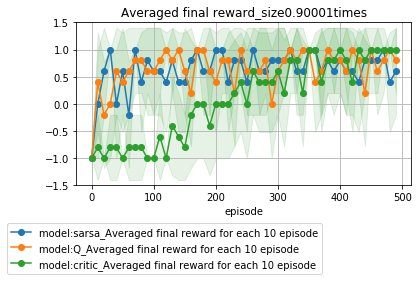

gamma:1.000010


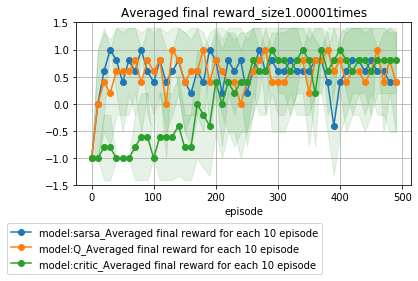

In [17]:
for i in np.arange(1e-5,1.1,0.1):
    print(f"gamma:{i:2f}")
    
    list = ["sarsa","Q","critic"]
    plt.figure(figsize=(6,3))
    plt.title("Averaged final reward_size{}times".format(i))
    for model in list:
        grid = np.array([[0, 0, 0, 0],[0, -1, 0, -1],[0,0,0,-1],[-1,0,0,1]])
        env = Environment(grid, move_prob=0.95, agent_init_state=(j, k))
        if model == "sarsa":
            agent = SARSAAgent(epsilon=0.1)
            agent.learn(env, gamma=i,  episode_num=500, alpha=0.1)
            agent.show_rewards_log(interval=10, model=model)
        elif model == "Q":
            # エージェントをつくる
            agent = QLearningAgent(epsilon=0.1)
            agent.learn(env, gamma=i,  episode_num=500, alpha=0.1)
            agent.show_rewards_log(interval=10, model=model)
        else:
            pass
            agent = ActorCriticAgent(Actor, Critic)

            # 学習の実行
            actor, critic = agent.learn(env, gamma=i,  episode_num=500, alpha=0.1)
            actor.show_rewards_log(interval=10, model=model)
    plt.show()
    plt.close()

criticは収束が遅いが、到達報酬は高い